In [ ]:
# -------------------------
# 1. Setup
# -------------------------
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from pyspark.ml.feature import RegexTokenizer
from pyspark.sql import SparkSession
 
df = pd.read_csv("author_chunks_dataset/train.csv")
df.head()
df.shape

(545285, 5)

## Section 1: Dataset Description & Initial EDA (Raw Works Level)

The dataset used here is the **raw dataset**:  
`author_identification_dataset_final.csv`  

- It contains **5,483 works** written by **1,625 authors**, along with metadata such as `title`, `genre`, `text_type`, and `word_count`.  
- Each row corresponds to a **full document/work**, not to pre‑chunked text.  
- This raw dataset is the foundation for later preprocessing (chunking, balancing, and splitting).  

📌 **Note:**  
When we later encounter chunk counts in the hundreds of thousands (e.g., ~545k rows in train split), those come from a **processed version** of this dataset, where long texts were split into manageable ~2000‑character chunks and capped at 1000 chunks per author for balance.  

For now, we focus on **exploring the original unchunked dataset** to understand:  
- How many authors are present (and which are most prolific).  
- Distribution of genres across works.  
- A preview of example rows.  

This gives us a **literary landscape view before preprocessing** and sets the stage for later sections.

Shape of dataset: (5483, 6)
Columns: ['author', 'title', 'text', 'genre', 'text_type', 'word_count']
Unique authors: 1625

Top 10 authors by number of works:
 author
William Wymark Jacobs              97
George Alfred Henty                89
R M Ballantyne                     88
Nathaniel Hawthorne                86
William Dean Howells               84
Robert Louis Stevenson             79
Various (Editor: Hugh Chisholm)    72
Henry James                        72
Anthony Trollope                   71
Charles Dickens                    61
Name: count, dtype: int64


C:\Users\lab_services_student\AppData\Local\Temp\ipykernel_5728\2477117737.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=author_counts.head(20).values,


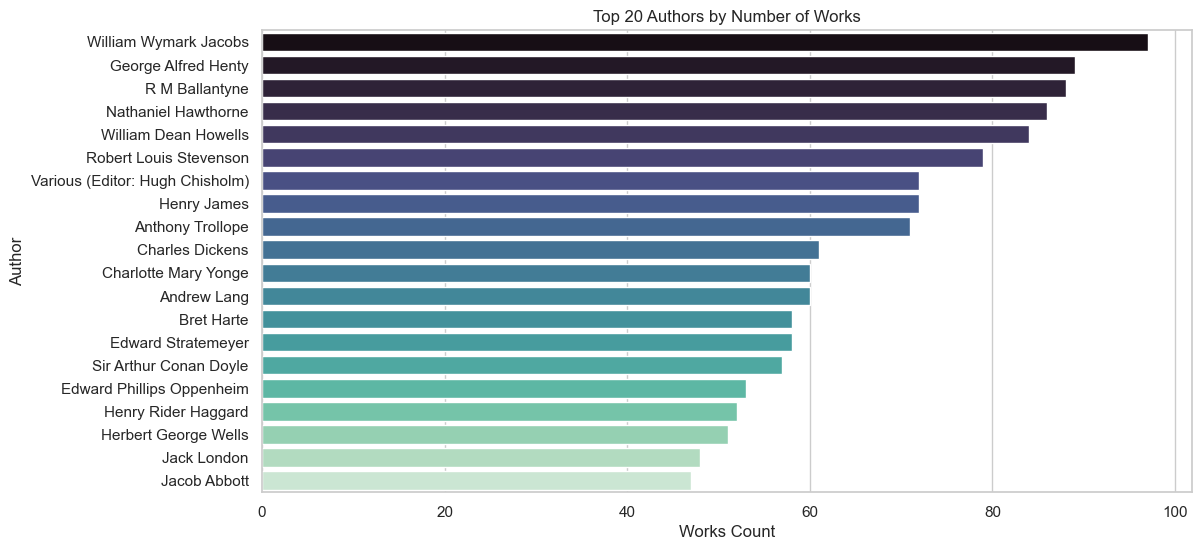


Unique genres: 580

Top 10 genres:
 genre
Poetry Collection                  89
Fiction, Novel                     77
History, Non-Fiction               74
Fiction, Short Stories             45
Drama/Play                         31
Adventure Fiction, Novel           30
Philosophy, Non-Fiction            28
Fiction, Short Story               28
Autobiography, Non-Fiction         27
Children's Fiction, Animal Tale    24
Name: count, dtype: int64


C:\Users\lab_services_student\AppData\Local\Temp\ipykernel_5728\2477117737.py:47: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_genres.values,


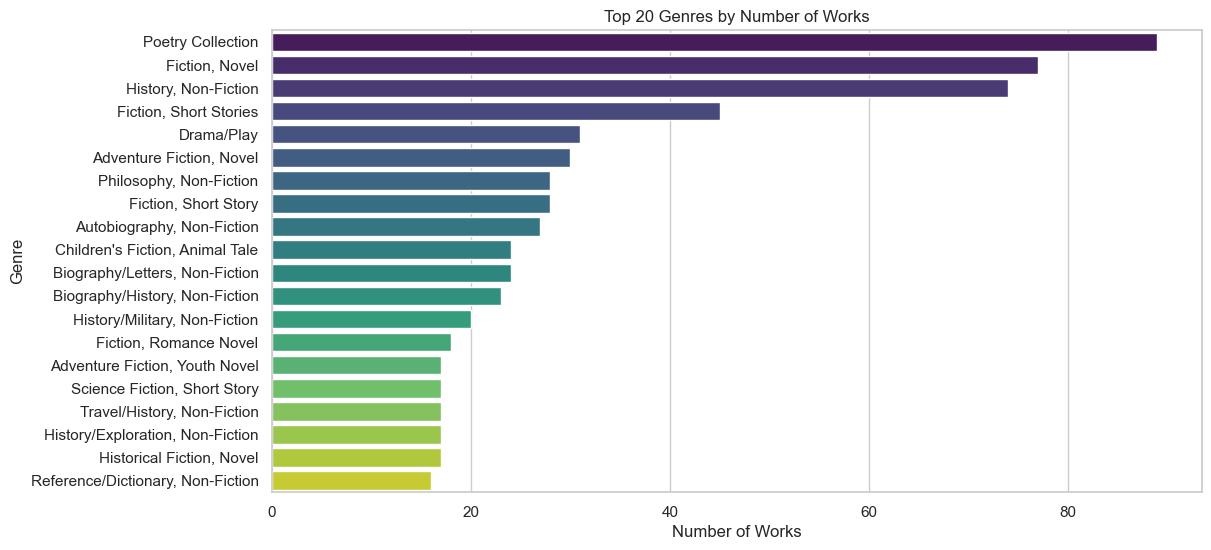

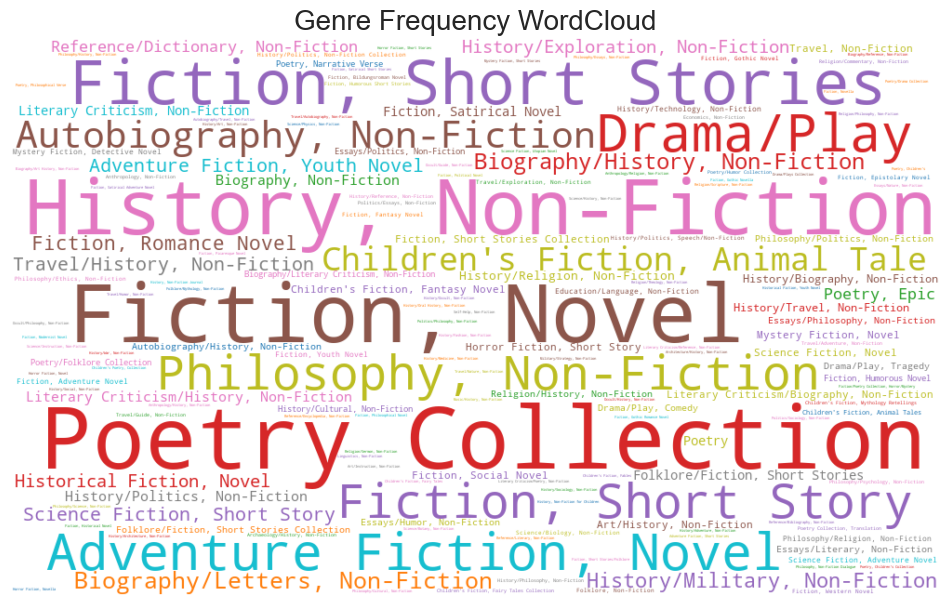


=== Example works (for report) ===

Author: Abraham Lincoln
Title: Lincoln Letters
Genre: History/Politics, Non-Fiction
---
Text snippet:
LINCOLN LETTERS By Abraham Lincoln Published by The Bibilophile Society NOTE The letters herein by Lincoln are so thoroughly characteristic of the man, and are in themselves so completely self-explanatory, that it requires no comment to enable the reader fully to understand and appreciate them. It w...

Author: Abraham Lincoln
Title: Lincoln's First Inaugural Address
Genre: History/Politics, Speech/Non-Fiction
---
Text snippet:
Lincoln's First Inaugural Address March 4, 1861 Fellow citizens of the United States: in compliance with a custom as old as the government itself, I appear before you to address you briefly and to take, in your presence, the oath prescribed by the Constitution of the United States, to be taken by th...

Author: Abraham Lincoln
Title: Lincoln's Inaugurals, Addresses and Letters (Selections)
Genre: History/Politics, Non-Fiction

In [ ]:
# -------------------------
# 1. Style configs
# -------------------------
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (10, 6)

# -------------------------
# 2. Load Original Dataset
# -------------------------
df = pd.read_csv("author_identification_dataset_final.csv")

print("Shape of dataset:", df.shape)
print("Columns:", df.columns.tolist())

# -------------------------
# 3. Author Counts
# -------------------------
n_authors = df['author'].nunique()
print("Unique authors:", n_authors)

author_counts = df['author'].value_counts()
print("\nTop 10 authors by number of works:\n", author_counts.head(10))

plt.figure(figsize=(12,6))
sns.barplot(x=author_counts.head(20).values,
            y=author_counts.head(20).index,
            palette="mako")
plt.title("Top 20 Authors by Number of Works")
plt.xlabel("Works Count")
plt.ylabel("Author")
plt.show()

# -------------------------
# 4. Genre Exploration
# -------------------------
n_genres = df['genre'].nunique()
print("\nUnique genres:", n_genres)

genre_counts = df['genre'].value_counts()
print("\nTop 10 genres:\n", genre_counts.head(10))

# Top N genres
top_n = 20
top_genres = genre_counts.head(top_n)

plt.figure(figsize=(12,6))
sns.barplot(x=top_genres.values,
            y=top_genres.index,
            palette="viridis")
plt.title(f"Top {top_n} Genres by Number of Works")
plt.xlabel("Number of Works")
plt.ylabel("Genre")
plt.show()

# -------------------------
# 5. WordCloud of Genres
# -------------------------
genre_wordcloud = WordCloud(width=1000, height=600,
                            background_color="white",
                            colormap="tab10",
                            prefer_horizontal=1.0
                           ).generate_from_frequencies(genre_counts)

plt.figure(figsize=(12,8))
plt.imshow(genre_wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Genre Frequency WordCloud", fontsize=20)
plt.show()

# -------------------------
# 6. Example Rows (Preview)
# -------------------------
print("\n=== Example works (for report) ===")
for genre in df['genre'].unique()[:3]:  # sample 3 genres
    sample_row = df[df['genre'] == genre].iloc[0]
    print(f"\nAuthor: {sample_row['author']}\nTitle: {sample_row['title']}\nGenre: {sample_row['genre']}\n---\nText snippet:\n{sample_row['text'][:300]}...\n{'='*80}")

## Section 2: Preprocessing EDA (Chunk Level)

After chunking, the dataset expands significantly because each original work
is split into ~2000-character text segments. Here, we explore the distribution
and balance of these chunks.

- **Step 1:** Show the distribution of chunk lengths.  
- **Step 2:** Show imbalance of chunks per author **before balancing**.  
- **Step 3:** Show distribution after capping (max 1000 chunks per author).  

This way we can visually demonstrate how preprocessing normalizes the data and
prepares it for feature extraction or deep learning models.

Raw dataset shape (before balance): (1526225, 4)
Balanced dataset shape (train split): (545285, 5)


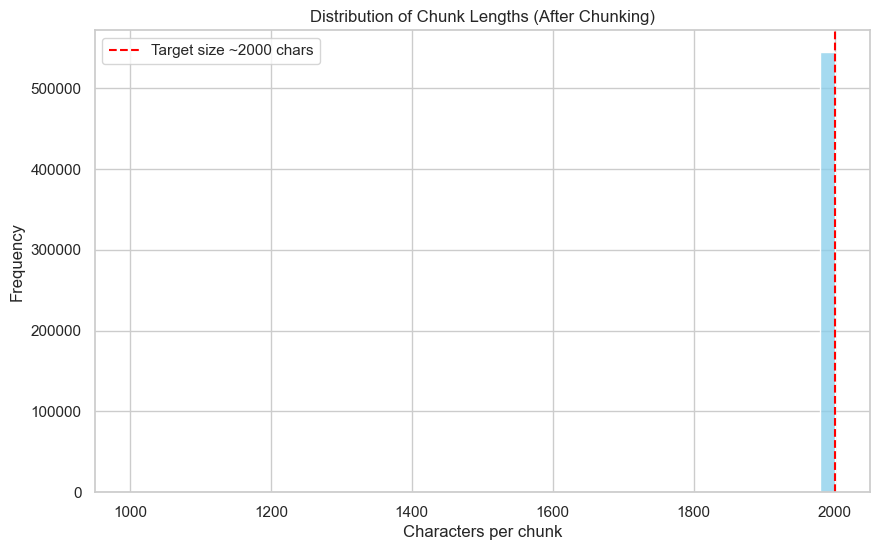

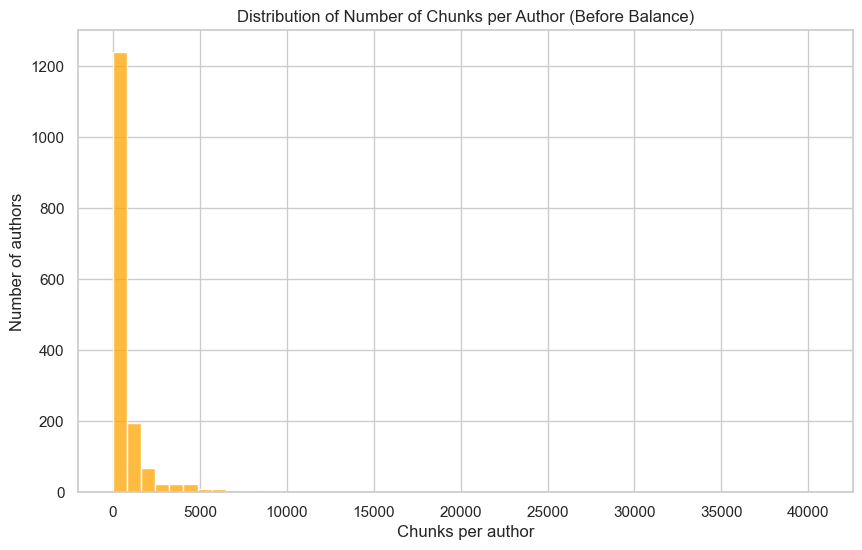

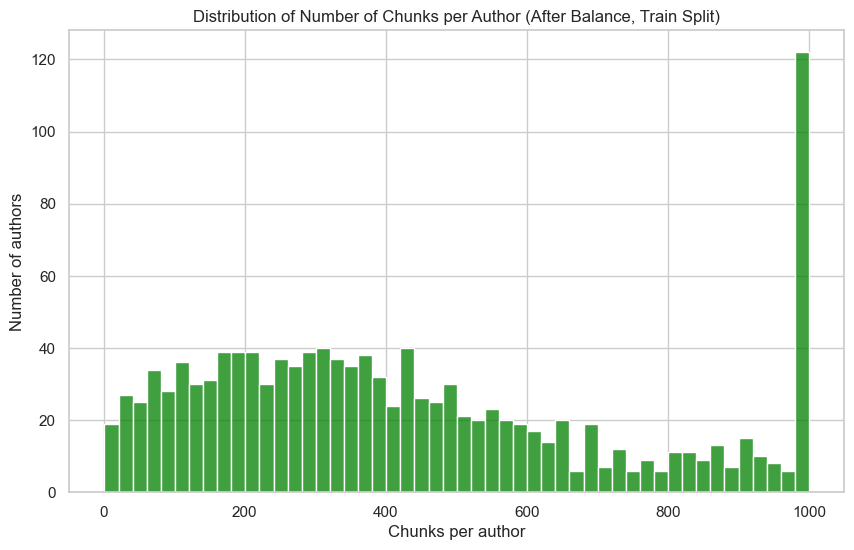

✅ Preprocessing EDA complete: The data is chunked, capped, and ready for feature extraction / deep models.


In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# -------------------------
# 1. Load chunked datasets
# -------------------------
df_raw = pd.read_csv("author_chunks_dataset/full_dataset.csv")    # Before balancing
df_train = pd.read_csv("author_chunks_dataset/train.csv")         # After balancing (train split)

print("Raw dataset shape (before balance):", df_raw.shape)
print("Balanced dataset shape (train split):", df_train.shape)

# -------------------------
# 2. Distribution of Chunk Lengths
# -------------------------
df_train['chunk_length'] = df_train['chunk'].str.len()

plt.figure(figsize=(10,6))
sns.histplot(df_train['chunk_length'], bins=50, color="skyblue")
plt.axvline(2000, color="red", linestyle="--", label="Target size ~2000 chars")
plt.title("Distribution of Chunk Lengths (After Chunking)")
plt.xlabel("Characters per chunk")
plt.ylabel("Frequency")
plt.legend()
plt.show()

# -------------------------
# 3. Imbalance Before Balancing
# -------------------------
raw_counts = df_raw['author'].value_counts()

plt.figure(figsize=(10,6))
sns.histplot(raw_counts, bins=50, color="orange")
plt.title("Distribution of Number of Chunks per Author (Before Balance)")
plt.xlabel("Chunks per author")
plt.ylabel("Number of authors")
plt.show()

# -------------------------
# 4. Balanced Author Distribution
# -------------------------
balanced_counts = df_train['author'].value_counts()

plt.figure(figsize=(10,6))
sns.histplot(balanced_counts, bins=50, color="green")
plt.title("Distribution of Number of Chunks per Author (After Balance, Train Split)")
plt.xlabel("Chunks per author")
plt.ylabel("Number of authors")
plt.show()

# -------------------------
# 5. Conclusion marker
# -------------------------
print("✅ Preprocessing EDA complete: The data is chunked, capped, and ready for feature extraction / deep models.")

## Section 3A: Classical Stylometry Features with PySpark

In this section, we move from dataset exploration (EDA) to **feature engineering** using
a *classical stylometry* approach. Unlike deep learning, which learns features implicitly,
here we explicitly design features that capture an author's writing style, and then train
traditional ML classifiers on these features.

### Why Stylometry?
Stylometry is the quantitative study of writing style — it has long been used for tasks such
as authorship attribution. By extracting measurable patterns from text, we can build a set
of **explainable features** that highlight stylistic differences between authors.

### Why PySpark?
- The dataset is large (~770k chunks after preprocessing).  
- PySpark allows us to efficiently compute features in a **distributed manner**.  
- This provides scalability beyond Pandas and demonstrates use of Spark in the workflow.

---

### Stylometric Features Extracted

We extract multiple categories of features, using Spark UDFs and transformations:

1. **Structural Features**  
   - `word_count`: Number of words in the chunk.  
   - `avg_word_len`: Average length of words.  
   - `avg_sentence_len`: Approximate sentence length (via ratio of characters to words).  

2. **Lexical Features**  
   - `type_token_ratio (TTR)`: Vocabulary richness, i.e., unique words / total words.  

3. **Function Word Usage**  
   - `function_word_ratio`: Proportion of stopwords (e.g., “and”, “the”, “to”) relative to all words.  

4. **Punctuation Frequencies**  
   - `comma_freq`: Number of commas.  
   - `semicolon_freq`: Number of semicolons.  
   - `qmark_freq`: Number of question marks.  

5. **(Optional Extension: Syntactic Features)**  
   - POS (part‑of‑speech) tag distributions (using spaCy or NLTK inside UDFs).  

---

### Workflow Steps

1. **Load Data**: Load `train.csv`, `dev.csv`, and `test.csv` splits into Spark DataFrames.  
2. **Tokenization**: Split text into word tokens using `RegexTokenizer`.  
3. **Feature Engineering**: Apply Spark UDFs to compute stylometry features per chunk.  
4. **Vector Assembly**: Collect features into a `features` vector column with `VectorAssembler`.  
5. **Author Label Encoding**: Convert author names to numeric labels via `StringIndexer`.  
6. **Model Training**: Train baseline ML models such as Logistic Regression and Random Forest using PySpark MLlib.  
7. **Evaluation**: Compute accuracy (and possibly extend to F1 / confusion matrix).  

---

### Why This Matters
This pipeline provides a **transparent, interpretable baseline**. By examining feature weights,
we can see what kinds of stylistic elements (word length, punctuation usage, etc.) matter for
authorship attribution.  

Later, in **Section 3B**, we will complement this approach with **deep learning (LSTM)**, which
models sequence information directly without manual feature design.

In [1]:
from pyspark.sql import SparkSession

# Start Spark session
spark = SparkSession.builder.appName("StylometryFeatures").getOrCreate()

# Load train/dev/test splits (balanced + chunked in previous step)
train_df = spark.read.csv("author_chunks_dataset/train.csv", header=True)
dev_df   = spark.read.csv("author_chunks_dataset/dev.csv", header=True)
test_df  = spark.read.csv("author_chunks_dataset/test.csv", header=True)

# Quick check
print("Train shape:", train_df.count(), "rows")
print("Columns:", train_df.columns)

Train shape: 545285 rows
Columns: ['author', 'book_id', 'genre', 'chunk', 'split']


In [2]:
from pyspark.ml.feature import RegexTokenizer

# Tokenize into words (ignore punctuation via \W regex)
tokenizer = RegexTokenizer(inputCol="chunk", outputCol="tokens", pattern="\\W")
train_df = tokenizer.transform(train_df)
dev_df   = tokenizer.transform(dev_df)
test_df  = tokenizer.transform(test_df)



In [3]:
from pyspark.sql.functions import size

# Step 2.5: Sanitize after tokenization
train_df = train_df.filter(train_df["chunk"].isNotNull()).filter(train_df["chunk"] != "")
train_df = train_df.filter(size(train_df["tokens"]) > 0)

dev_df = dev_df.filter(dev_df["chunk"].isNotNull()).filter(dev_df["chunk"] != "")
dev_df = dev_df.filter(size(dev_df["tokens"]) > 0)

test_df = test_df.filter(test_df["chunk"].isNotNull()).filter(test_df["chunk"] != "")
test_df = test_df.filter(size(test_df["tokens"]) > 0)

In [4]:

import re
from nltk.corpus import stopwords
from pyspark.sql.functions import udf, size, length
from pyspark.sql.types import DoubleType, IntegerType

stoplist = set(stopwords.words('english'))

# Avg word length
def avg_word_len(tokens):
    if tokens and len(tokens) > 0:
        return float(sum(len(t) for t in tokens) / len(tokens))
    return 0.0

# Type-token ratio
def type_token_ratio(tokens):
    if tokens and len(tokens) > 0:
        return float(len(set(tokens)) / len(tokens))
    return 0.0

# Function word ratio
def func_word_ratio(tokens):
    if tokens and len(tokens) > 0:
        return float(sum(1 for t in tokens if t.lower() in stoplist) / len(tokens))
    return 0.0

# Punctuation counts
def punct_count(text, symbol=","):
    if text:
        return float(text.count(symbol))
    return 0.0

# Register UDFs
avg_word_len_udf = udf(avg_word_len, DoubleType())
ttr_udf          = udf(type_token_ratio, DoubleType())
func_ratio_udf   = udf(func_word_ratio, DoubleType())
comma_udf        = udf(lambda txt: punct_count(txt, ","), DoubleType())
semicolon_udf    = udf(lambda txt: punct_count(txt, ";"), DoubleType())
qmark_udf        = udf(lambda txt: punct_count(txt, "?"), DoubleType())

In [5]:
# Word count
train_df = train_df.withColumn("word_count", size("tokens"))

# Structural
train_df = train_df.withColumn("avg_word_len", avg_word_len_udf("tokens"))
train_df = train_df.withColumn("ttr", ttr_udf("tokens"))
train_df = train_df.withColumn("func_word_ratio", func_ratio_udf("tokens"))

# Punctuation
train_df = train_df.withColumn("comma_freq", comma_udf("chunk"))
train_df = train_df.withColumn("semicolon_freq", semicolon_udf("chunk"))
train_df = train_df.withColumn("qmark_freq", qmark_udf("chunk"))

# For dev_df
dev_df = dev_df.withColumn("word_count", size("tokens"))
dev_df = dev_df.withColumn("avg_word_len", avg_word_len_udf("tokens"))
dev_df = dev_df.withColumn("ttr", ttr_udf("tokens"))
dev_df = dev_df.withColumn("func_word_ratio", func_ratio_udf("tokens"))
dev_df = dev_df.withColumn("comma_freq", comma_udf("chunk"))
dev_df = dev_df.withColumn("semicolon_freq", semicolon_udf("chunk"))
dev_df = dev_df.withColumn("qmark_freq", qmark_udf("chunk"))

# For test_df
test_df = test_df.withColumn("word_count", size("tokens"))
test_df = test_df.withColumn("avg_word_len", avg_word_len_udf("tokens"))
test_df = test_df.withColumn("ttr", ttr_udf("tokens"))
test_df = test_df.withColumn("func_word_ratio", func_ratio_udf("tokens"))
test_df = test_df.withColumn("comma_freq", comma_udf("chunk"))
test_df = test_df.withColumn("semicolon_freq", semicolon_udf("chunk"))
test_df = test_df.withColumn("qmark_freq", qmark_udf("chunk"))

In [6]:
# from pyspark.ml.feature import VectorAssembler

# feature_cols = ["word_count", "avg_word_len", "ttr", "func_word_ratio",
#                 "comma_freq", "semicolon_freq", "qmark_freq"]

# assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")

# train_df = assembler.transform(train_df)
# dev_df   = assembler.transform(dev_df)
# test_df  = assembler.transform(test_df)

# test_df  = assembler.transform(test_df)
# Feature columns
feature_cols = ["word_count", "avg_word_len", "ttr", "func_word_ratio",
                "comma_freq", "semicolon_freq", "qmark_freq"]

# Combine with label
final_cols = feature_cols + ["author"]

# Spark → Pandas
pdf_train = train_df.select(final_cols).toPandas()
pdf_dev   = dev_df.select(final_cols).toPandas()
pdf_test  = test_df.select(final_cols).toPandas()

print("Train shape:", pdf_train.shape)
print("Dev shape:", pdf_dev.shape)
print("Test shape:", pdf_test.shape)
print("Features:", feature_cols)

Train shape: (545264, 8)
Dev shape: (112943, 8)
Test shape: (111778, 8)
Features: ['word_count', 'avg_word_len', 'ttr', 'func_word_ratio', 'comma_freq', 'semicolon_freq', 'qmark_freq']


In [9]:
# from pyspark.ml.feature import StringIndexer

# indexer = StringIndexer(inputCol="author", outputCol="label").fit(train_df)

# train_df = indexer.transform(train_df)
# dev_df   = indexer.transform(dev_df)
# test_df  = indexer.transform(test_df)

from sklearn.preprocessing import LabelEncoder
import pandas as pd

# Fit encoder across all splits
all_authors = pd.concat([pdf_train["author"], pdf_dev["author"], pdf_test["author"]])
le = LabelEncoder().fit(all_authors)

y_train = le.transform(pdf_train["author"])
y_dev   = le.transform(pdf_dev["author"])
y_test  = le.transform(pdf_test["author"])

X_train = pdf_train[feature_cols]
X_dev   = pdf_dev[feature_cols]
X_test  = pdf_test[feature_cols]

print("Number of Authors (classes):", len(le.classes_))

Number of Authors (classes): 1624


In [ ]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(max_iter=200, multi_class="multinomial", solver="saga")
lr.fit(X_train, y_train)

print("Train Accuracy:", lr.score(X_train, y_train))
print("Dev Accuracy:", lr.score(X_dev, y_dev))

c:\tools\Anaconda3\envs\pyspark_env\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


In [ ]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=200, random_state=42, n_jobs=-1)
rf.fit(X_train, y_train)

print("Train Accuracy:", rf.score(X_train, y_train))
print("Dev Accuracy:", rf.score(X_dev, y_dev))

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Logistic Regression coefficients
coef_df = pd.DataFrame(lr.coef_[0], index=feature_cols, columns=["coef"])
coef_df.sort_values("coef").plot(kind="barh", figsize=(8,6), title="Logistic Regression Coefficients")
plt.show()

# Random Forest feature importances
imp_df = pd.DataFrame(rf.feature_importances_, index=feature_cols, columns=["importance"])
sns.barplot(x="importance", y=imp_df.index, data=imp_df.sort_values("importance", ascending=False))
plt.title("Random Forest Feature Importance")
plt.show()